# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon


## Step 1: Download the Kaggle dataset using the kaggle python library

1. Notebook instance used - `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install required packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [2]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "username"
kaggle_key = "key"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

## Step 2: Data Exploration

### Go to the bike sharing demand competition and agree to the terms
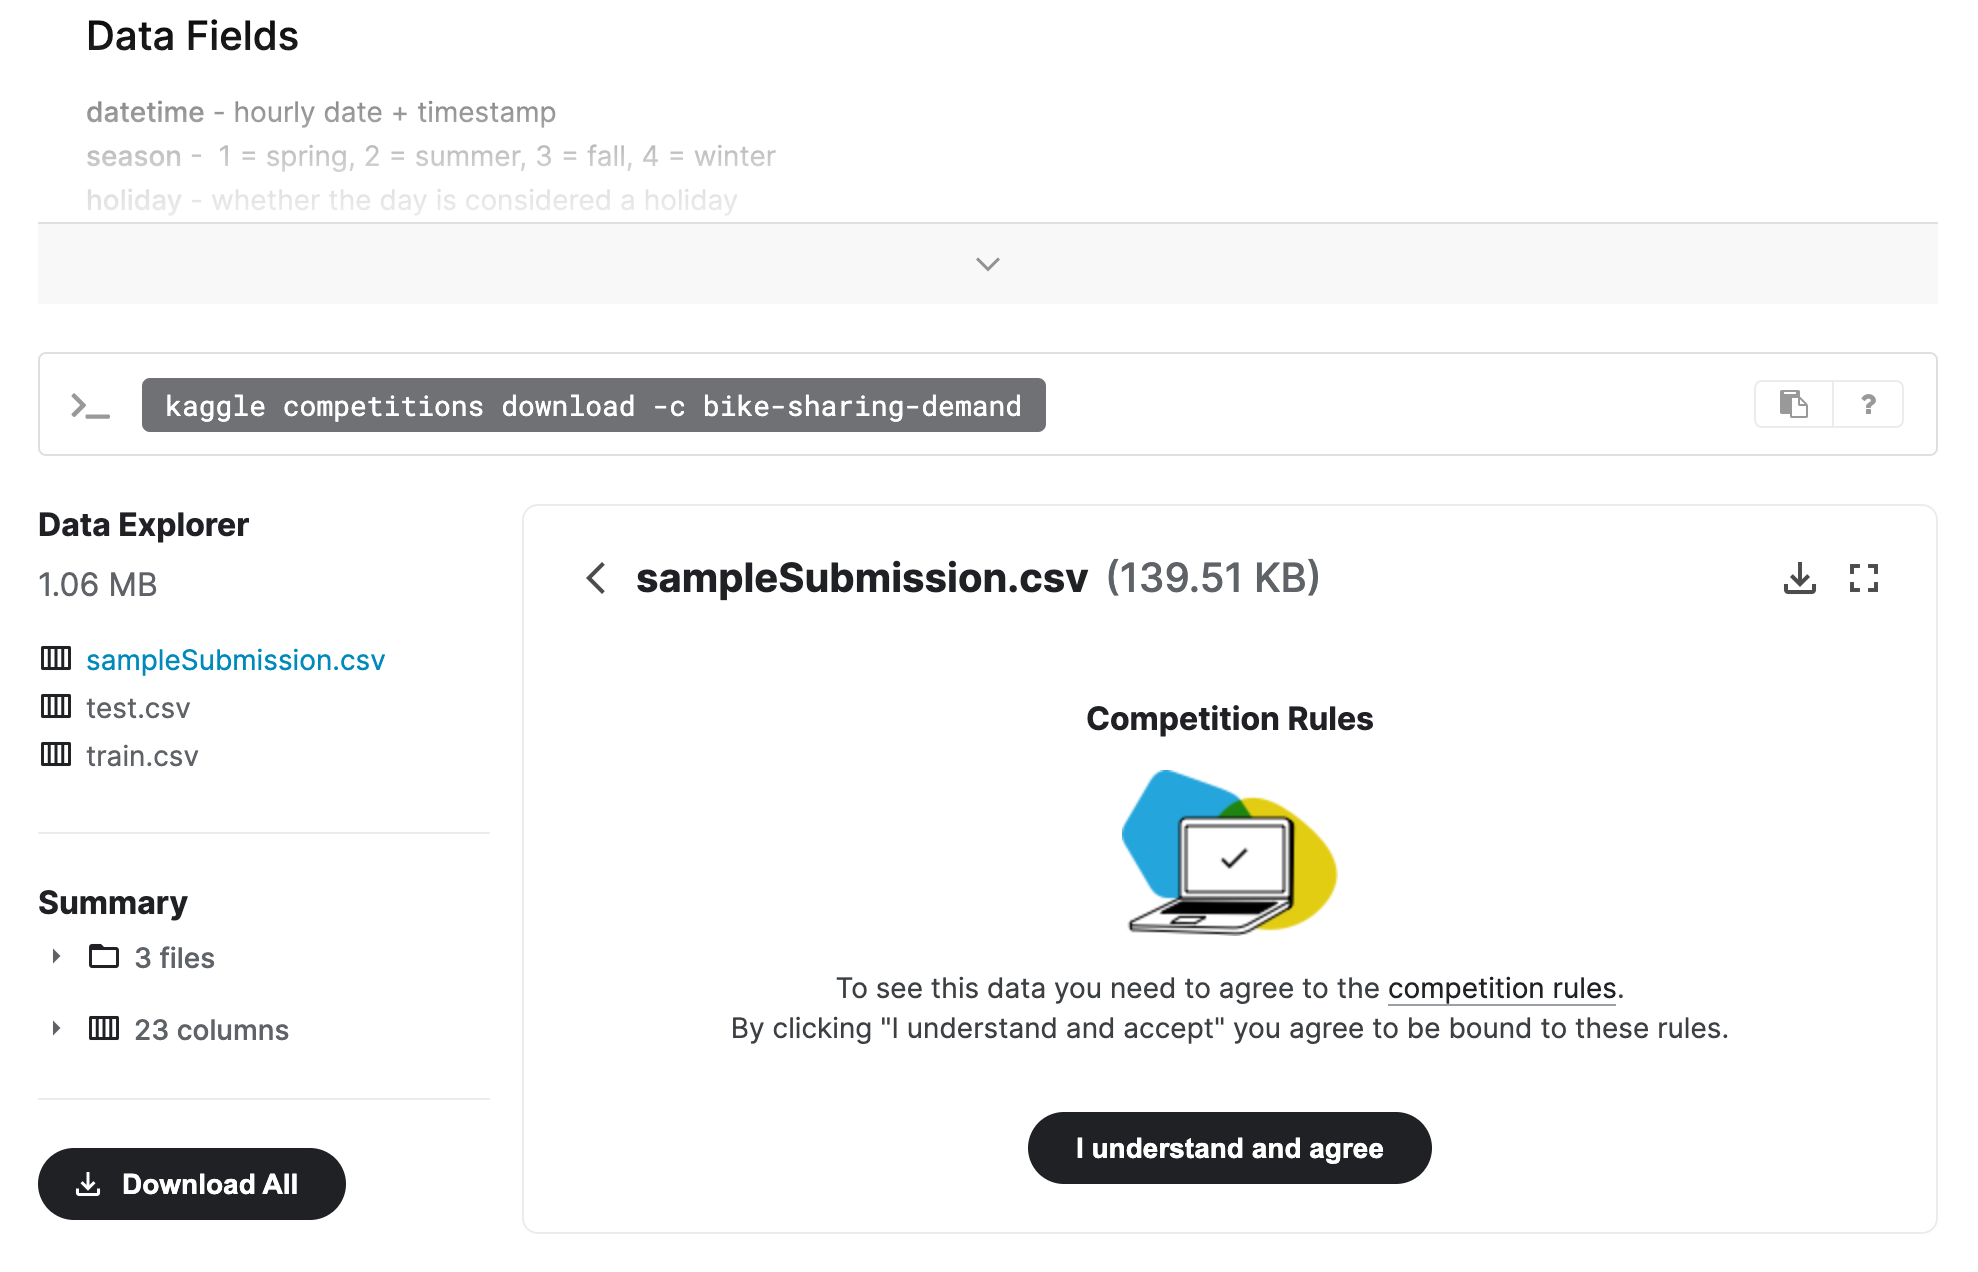

In [4]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [7]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates = ['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [9]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates = ['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [11]:
df_train=train.drop(['casual', 'registered'], axis=1)

In [12]:
predictor = TabularPredictor(label="count", eval_metric = 'root_mean_squared_error').fit(train_data=df_train, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20211102_141734/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20211102_141734/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3179.23 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column va

[1000]	train_set's rmse: 123.806	valid_set's rmse: 134.369
[2000]	train_set's rmse: 117.412	valid_set's rmse: 133.705


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 123.42	valid_set's rmse: 141.5


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 125.097	valid_set's rmse: 128.797
[2000]	train_set's rmse: 119.003	valid_set's rmse: 127.909
[3000]	train_set's rmse: 114.63	valid_set's rmse: 127.431
[4000]	train_set's rmse: 111.295	valid_set's rmse: 126.943
[5000]	train_set's rmse: 108.576	valid_set's rmse: 126.844
[6000]	train_set's rmse: 106.085	valid_set's rmse: 126.71


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.131	valid_set's rmse: 138.303
[2000]	train_set's rmse: 117.833	valid_set's rmse: 137.535


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.871	valid_set's rmse: 128.052
[2000]	train_set's rmse: 118.547	valid_set's rmse: 127.003
[3000]	train_set's rmse: 114.124	valid_set's rmse: 126.834
[4000]	train_set's rmse: 110.645	valid_set's rmse: 126.694


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.654	valid_set's rmse: 135.095
[2000]	train_set's rmse: 118.764	valid_set's rmse: 133.849
[3000]	train_set's rmse: 114.615	valid_set's rmse: 133.509
[4000]	train_set's rmse: 111.249	valid_set's rmse: 133.472
[5000]	train_set's rmse: 108.455	valid_set's rmse: 133.281


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.01	valid_set's rmse: 139.355
[2000]	train_set's rmse: 117.819	valid_set's rmse: 138.312
[3000]	train_set's rmse: 113.4	valid_set's rmse: 137.886
[4000]	train_set's rmse: 110.032	valid_set's rmse: 137.758


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.47	valid_set's rmse: 135.412


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.18	valid_set's rmse: 137.579
[2000]	train_set's rmse: 117.782	valid_set's rmse: 136.664
[3000]	train_set's rmse: 113.447	valid_set's rmse: 136.246
[4000]	train_set's rmse: 109.982	valid_set's rmse: 136.227


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.641	valid_set's rmse: 132.484


	-134.0883	 = Validation score   (root_mean_squared_error)
	45.5s	 = Training   runtime
	2.24s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 345.34s of the 545.36s of remaining time.
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argu

[1000]	train_set's rmse: 96.0217	valid_set's rmse: 123.249


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 94.7479	valid_set's rmse: 135.635


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.3055	valid_set's rmse: 132.087


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.1635	valid_set's rmse: 131.521


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-132.2864	 = Validation score   (root_mean_squared_error)
	12.82s	 = Training   runtime
	0.46s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 330.08s of the 530.1s of remaining time.
	-118.4567	 = Validation score   (root_mean_squared_error)
	7.07s	 = Training   runtime


### Review AutoGluon's training run with ranking of models that did the best.

In [13]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -114.853277       6.798198  535.005020                0.000764           0.357307            3       True         19
1   NeuralNetFastAI_BAG_L2 -115.462287       5.950707  469.807502                0.331967          98.174909            2       True         17
2          CatBoost_BAG_L2 -116.272408       5.654256  404.958817                0.035516          33.326225            2       True         15
3        LightGBMXT_BAG_L2 -116.410800       5.828182  382.374137                0.209442          10.741545            2       True         12
4          LightGBM_BAG_L2 -116.817671       5.696871  378.826672                0.078131           7.194079            2       True         13
5           XGBoost_BAG_L2 -117.404569       5.695536  378.964565         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetMXNet_BAG_L1': 'StackerEnsembleModel_TabularNeuralNet',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGB

### Create predictions from test dataset

In [14]:
predictions = predictor.predict(test)
predictions.head()

0     98.787132
1     90.939392
2     90.940239
3    110.249123
4    110.187492
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [15]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      211.595505
std       128.625595
min       -17.679968
25%       106.683884
50%       194.882538
75%       298.368652
max       657.951050
Name: count, dtype: float64

In [16]:
# How many negative values do we have?
(predictions<0).sum()

3

In [17]:
# Set them to zero
predictions[predictions<0] = 0

### Set predictions to submission dataframe, save, and submit

In [18]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [19]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 556kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [20]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2021-11-02 14:28:08  raw submission                     complete  1.39355      1.39355       
submission_new_hpo.csv       2021-11-02 14:07:44  new features with hyperparameters  complete  0.51139      0.51139       
submission_new_features.csv  2021-11-02 11:12:33  new features                       complete  0.45380      0.45380       
submission.csv               2021-11-02 10:50:43  first raw submission               complete  1.39238      1.39238       


#### Initial score of `1.39`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

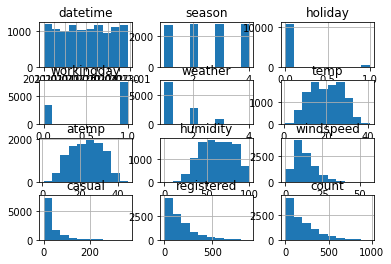

In [21]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [22]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [23]:
# create a new feature
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.weekday


test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['weekday'] = test['datetime'].dt.weekday

train = train.drop('datetime', axis = 1)
train = train.drop(['casual','registered'], axis = 1)
test = test.drop('datetime', axis = 1)

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [24]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [25]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,weekday
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4,5


array([[<AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'weekday'}>]], dtype=object)

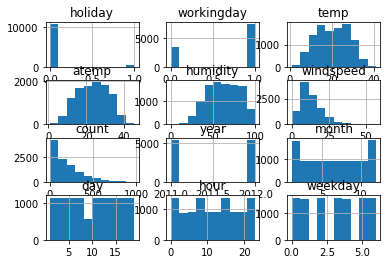

In [26]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [27]:
predictor_new_features = TabularPredictor(label='count', eval_metric = 'root_mean_squared_error').fit(train, presets='best_quality', time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20211102_142813/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20211102_142813/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2516.91 MB
	Train Data (Original)  Memory Usage: 0.98 MB (0.0% of available memory)
	Inferring data type of each feature based on column v

[1000]	train_set's rmse: 28.6163	valid_set's rmse: 36.5134
[2000]	train_set's rmse: 22.9702	valid_set's rmse: 34.2596
[3000]	train_set's rmse: 20.1858	valid_set's rmse: 33.8541
[4000]	train_set's rmse: 18.2791	valid_set's rmse: 33.776
[5000]	train_set's rmse: 16.8218	valid_set's rmse: 33.7282
[6000]	train_set's rmse: 15.6598	valid_set's rmse: 33.7603


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 28.2113	valid_set's rmse: 40.0611
[2000]	train_set's rmse: 22.9874	valid_set's rmse: 37.2505
[3000]	train_set's rmse: 20.3385	valid_set's rmse: 36.5258
[4000]	train_set's rmse: 18.4422	valid_set's rmse: 36.2574
[5000]	train_set's rmse: 17.0178	valid_set's rmse: 36.1223
[6000]	train_set's rmse: 15.8561	valid_set's rmse: 36.0315
[7000]	train_set's rmse: 14.8587	valid_set's rmse: 36.013
[8000]	train_set's rmse: 14.0052	valid_set's rmse: 35.9982
[9000]	train_set's rmse: 13.2605	valid_set's rmse: 36.0001


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 28.2572	valid_set's rmse: 32.8629
[2000]	train_set's rmse: 23.2511	valid_set's rmse: 31.3448
[3000]	train_set's rmse: 20.5647	valid_set's rmse: 31.1039
[4000]	train_set's rmse: 18.6787	valid_set's rmse: 31.0291
[5000]	train_set's rmse: 17.2376	valid_set's rmse: 31.0318


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 28.0563	valid_set's rmse: 39.2813
[2000]	train_set's rmse: 22.8646	valid_set's rmse: 37.1504
[3000]	train_set's rmse: 20.2354	valid_set's rmse: 36.5117
[4000]	train_set's rmse: 18.4503	valid_set's rmse: 36.2095
[5000]	train_set's rmse: 17.0745	valid_set's rmse: 36.0264
[6000]	train_set's rmse: 15.9063	valid_set's rmse: 35.82
[7000]	train_set's rmse: 14.9477	valid_set's rmse: 35.7034
[8000]	train_set's rmse: 14.1389	valid_set's rmse: 35.6084
[9000]	train_set's rmse: 13.4094	valid_set's rmse: 35.5745
[10000]	train_set's rmse: 12.7715	valid_set's rmse: 35.583


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 28.1458	valid_set's rmse: 36.5853
[2000]	train_set's rmse: 22.9452	valid_set's rmse: 34.7036
[3000]	train_set's rmse: 20.2613	valid_set's rmse: 34.5487
[4000]	train_set's rmse: 18.426	valid_set's rmse: 34.4196
[5000]	train_set's rmse: 16.9689	valid_set's rmse: 34.4381


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 28.0308	valid_set's rmse: 37.8682
[2000]	train_set's rmse: 22.8287	valid_set's rmse: 36.4583
[3000]	train_set's rmse: 20.096	valid_set's rmse: 36.1725
[4000]	train_set's rmse: 18.2508	valid_set's rmse: 36.1143
[5000]	train_set's rmse: 16.8345	valid_set's rmse: 36.1187


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 28.5224	valid_set's rmse: 38.3318
[2000]	train_set's rmse: 23.2013	valid_set's rmse: 35.0392
[3000]	train_set's rmse: 20.4699	valid_set's rmse: 34.0114
[4000]	train_set's rmse: 18.5791	valid_set's rmse: 33.6053
[5000]	train_set's rmse: 17.1089	valid_set's rmse: 33.3608
[6000]	train_set's rmse: 15.8987	valid_set's rmse: 33.2494
[7000]	train_set's rmse: 14.8925	valid_set's rmse: 33.1992
[8000]	train_set's rmse: 14.0193	valid_set's rmse: 33.1855


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 28.3868	valid_set's rmse: 37.2137
[2000]	train_set's rmse: 23.0291	valid_set's rmse: 35.3906
[3000]	train_set's rmse: 20.3307	valid_set's rmse: 35.0149
[4000]	train_set's rmse: 18.4199	valid_set's rmse: 34.9126
[5000]	train_set's rmse: 16.9434	valid_set's rmse: 34.8572
[6000]	train_set's rmse: 15.7795	valid_set's rmse: 34.8757


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 27.484	valid_set's rmse: 39.4259
[2000]	train_set's rmse: 22.6972	valid_set's rmse: 38.0415
[3000]	train_set's rmse: 20.1326	valid_set's rmse: 37.7033
[4000]	train_set's rmse: 18.3331	valid_set's rmse: 37.5197
[5000]	train_set's rmse: 16.8814	valid_set's rmse: 37.4413


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 27.9489	valid_set's rmse: 35.0349
[2000]	train_set's rmse: 23.1329	valid_set's rmse: 33.6254
[3000]	train_set's rmse: 20.5427	valid_set's rmse: 33.2265
[4000]	train_set's rmse: 18.7143	valid_set's rmse: 32.9731
[5000]	train_set's rmse: 17.2593	valid_set's rmse: 32.8442
[6000]	train_set's rmse: 16.074	valid_set's rmse: 32.7649
[7000]	train_set's rmse: 15.1096	valid_set's rmse: 32.7602
[8000]	train_set's rmse: 14.2508	valid_set's rmse: 32.7413
[9000]	train_set's rmse: 13.5028	valid_set's rmse: 32.7025
[10000]	train_set's rmse: 12.8285	valid_set's rmse: 32.7231


	-34.5297	 = Validation score   (root_mean_squared_error)
	103.6s	 = Training   runtime
	4.94s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 278.05s of the 478.11s of remaining time.
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 19.8144	valid_set's rmse: 34.5176


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 19.846	valid_set's rmse: 34.427
[2000]	train_set's rmse: 14.3039	valid_set's rmse: 33.7285
[3000]	train_set's rmse: 11.2663	valid_set's rmse: 33.4853


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 19.8697	valid_set's rmse: 29.0867


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 19.766	valid_set's rmse: 36.3595
[2000]	train_set's rmse: 14.3417	valid_set's rmse: 35.4445
[3000]	train_set's rmse: 11.4008	valid_set's rmse: 35.0991
[4000]	train_set's rmse: 9.15962	valid_set's rmse: 34.9405
[5000]	train_set's rmse: 7.59445	valid_set's rmse: 34.8644
[6000]	train_set's rmse: 6.36802	valid_set's rmse: 34.8052


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 19.8315	valid_set's rmse: 36.0416
[2000]	train_set's rmse: 14.1709	valid_set's rmse: 35.4921


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 19.6911	valid_set's rmse: 36.9723
[2000]	train_set's rmse: 14.2916	valid_set's rmse: 36.4007


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 19.7018	valid_set's rmse: 32.2929


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 19.3621	valid_set's rmse: 33.113
[2000]	train_set's rmse: 14.0321	valid_set's rmse: 32.7125


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 19.6231	valid_set's rmse: 38.0794


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 19.7985	valid_set's rmse: 34.8811
[2000]	train_set's rmse: 14.4693	valid_set's rmse: 34.3345


	-34.1556	 = Validation score   (root_mean_squared_error)
	35.45s	 = Training   runtime
	1.39s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 236.79s of the 436.84s of remaining time.
	-38.9173	 = Validation score   (root_mean_squared_error)
	8.45s	 = Training   runtime
	0.41s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 225.25s of the 425.31s of remaining time.
	Time limit exceeded... Skipping CatBoost_BAG_L1.
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 175.4s of the 375.46s of remaining time.
	-38.7202	 = Validation score   (root_mean_squared_error)
	3.94s	 = Training   runtime
	0.4s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 168.32s of the 368.37s of remaining time.
	Ran out of time, stopping training early. (Stopping on epoch 28)
	Ran out of time, stopping training early. (Stopping on epoch 29)
	-45.0535	 = Validation score   (root_mean_s

In [28]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -32.339708       9.701942  490.773665                0.000782           0.324743            3       True         16
1          CatBoost_BAG_L2  -32.561406       8.268546  355.774941                0.064317          45.326749            2       True         13
2      WeightedEnsemble_L2  -32.582678       7.438205  176.135019                0.000749           0.394021            2       True          9
3     ExtraTreesMSE_BAG_L2  -32.875508       8.670866  317.198827                0.466637           6.750635            2       True         14
4          LightGBM_BAG_L2  -32.981304       8.300726  317.292540                0.096497           6.844349            2       True         11
5   NeuralNetFastAI_BAG_L2  -33.106016       8.606326  406.641295         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -120.0126048837036,
  'KNeighborsDist_BAG_L1': -115.0704805382924,
 

In [29]:
prediction_new_features = predictor_new_features.predict(test)
prediction_new_features.head()

0    14.780790
1     6.021924
2     5.045782
3     3.627265
4     4.023268
Name: count, dtype: float32

In [30]:
prediction_new_features.describe()

count    6493.000000
mean      189.654358
std       172.906479
min         1.390364
25%        46.453129
50%       147.664032
75%       279.639923
max       890.691467
Name: count, dtype: float64

In [31]:
# Remember to set all negative values to zero
prediction_new_features[prediction_new_features<0] = 0

In [32]:
submission_new_features = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [33]:
# Same submitting predictions
submission_new_features["count"] = prediction_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [34]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 605kB/s]
Successfully submitted to Bike Sharing Demand

In [35]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2021-11-02 14:39:09  new features                       complete  0.45368      0.45368       
submission.csv               2021-11-02 14:28:08  raw submission                     complete  1.39355      1.39355       
submission_new_hpo.csv       2021-11-02 14:07:44  new features with hyperparameters  complete  0.51139      0.51139       
submission_new_features.csv  2021-11-02 11:12:33  new features                       complete  0.45380      0.45380       


#### New Score of `0.45380`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [37]:
import autogluon.core as ag
time_limit = 10*60
nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'layers': ag.space.Categorical([100], [1000], [200, 100], [300, 200, 100]),  # each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using Bayesian optimization routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#     'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor_new_hpo = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(train, presets='best_quality', time_limit=time_limit, hyperparameters={'NN': nn_options, 'GBM': gbm_options}, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

No path specified. Models will be saved in: "AutogluonModels/ag-20211102_143927/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20211102_143927/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1872.56 MB
	Train Data (Original)  Memory Usage: 0.98 MB (0.1% of available memory)
	Inferring data type of each feature based on column v

In [38]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -39.010497       9.889194  389.454629                0.000668           0.316058            3       True         28
1         LightGBM_BAG_L2/T4  -39.246174       7.496683  288.608807                0.098551           5.715730            2       True         22
2         LightGBM_BAG_L2/T3  -39.247715       7.500235  288.547190                0.102103           5.654113            2       True         21
3         LightGBM_BAG_L2/T2  -39.259308       7.501241  288.395046                0.103109           5.501969            2       True         20
4         LightGBM_BAG_L2/T5  -39.270847       7.499222  288.450274                0.101090           5.557197            2       True         23
5         LightGBM_BAG_L2/T6  -39.277672       7.502181  288.5

{'model_types': {'LightGBM_BAG_L1/T0': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T6': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T7': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T8': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T9': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T10': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T11': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T12': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T13': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T14': 'StackerEnsembleModel_LGB',
  'NeuralNetMXNet_BAG_L1/T0': 'StackerEnsembleModel_TabularNeuralNet',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T0': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T1': 'St

In [39]:
prediction_new_features_hpo = predictor_new_hpo.predict(test)
prediction_new_features_hpo.head()

0    10.018309
1     7.771845
2     7.496772
3     7.309323
4     7.286833
Name: count, dtype: float32

In [40]:
# Remember to set all negative values to zero
prediction_new_features_hpo[prediction_new_features_hpo<0] = 0

In [41]:
submission_new_hpo = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [42]:
# Same submitting predictions
submission_new_hpo["count"] = prediction_new_features_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [43]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 523kB/s]
Successfully submitted to Bike Sharing Demand

In [44]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2021-11-02 14:47:57  new features with hyperparameters  complete  0.50056      0.50056       
submission_new_features.csv  2021-11-02 14:39:09  new features                       complete  0.45368      0.45368       
submission.csv               2021-11-02 14:28:08  raw submission                     complete  1.39355      1.39355       
submission_new_hpo.csv       2021-11-02 14:07:44  new features with hyperparameters  complete  0.51139      0.51139       


## Step 7: Hyper parameter optimization 2
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [45]:
import autogluon.core as ag
time_limit = 20*60
nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 20,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'layers': ag.space.Categorical([100], [1000], [200, 100], [300, 200, 100]),  # each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 200,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

search_strategy = 'auto'  # to tune hyperparameters using Bayesian optimization routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor_new_hpo2 = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(train, presets='best_quality', time_limit=time_limit, hyperparameters={'NN': nn_options, 'GBM': gbm_options}, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

No path specified. Models will be saved in: "AutogluonModels/ag-20211102_144759/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "AutogluonModels/ag-20211102_144759/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1858.23 MB
	Train Data (Original)  Memory Usage: 0.98 MB (0.1% of available memory)
	Inferring data type of each feature based on column 

In [46]:
predictor_new_hpo2.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3 -36.742658      14.299536  786.753311                0.000772           0.325634            3       True         40
1        WeightedEnsemble_L2 -37.036558       0.998580   31.814752                0.000691           0.310951            2       True         25
2         LightGBM_BAG_L1/T9 -37.056045       0.334572   10.470546                0.334572          10.470546            1       True         10
3        LightGBM_BAG_L1/T18 -37.063108       0.336268   10.542892                0.336268          10.542892            1       True         19
4         LightGBM_BAG_L1/T7 -37.065213       0.327048   10.490364                0.327048          10.490364            1       True          8
5        LightGBM_BAG_L1/T16 -37.073449       0.340911   10.463321  

{'model_types': {'LightGBM_BAG_L1/T0': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T6': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T7': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T8': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T9': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T10': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T11': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T12': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T13': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T14': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T15': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T16': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T17': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T18': 'StackerEnsemble

In [47]:
prediction_new_features_hpo2 = predictor_new_hpo2.predict(test)
prediction_new_features_hpo2.head()

0    12.782135
1     5.158878
2     4.043981
3     3.543866
4     3.544867
Name: count, dtype: float32

In [48]:
# Remember to set all negative values to zero
prediction_new_features_hpo2[prediction_new_features_hpo2<0] = 0

In [49]:
submission_new_hpo2 = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_hpo2.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [50]:
# Same submitting predictions
submission_new_hpo2["count"] = prediction_new_features_hpo2
submission_new_hpo2.to_csv("submission_new_hpo2.csv", index=False)

In [51]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters 2"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 556kB/s]
Successfully submitted to Bike Sharing Demand

#### New Score of `0.51139`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo", "hpo2"],
        "score": [?, ?, ?]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

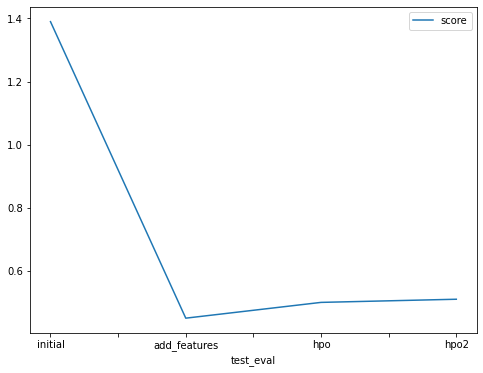

In [52]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo", "hpo2"],
        "score": [1.39, 0.45, 0.50, 0.51]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [53]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo", "hpo2"],
    "num_epochs": ['default', 'default', 10, 20],
    "num_boost_round": ['default', 'default', 100, 200],
    "time": [600, 600, 600, 900],
    "score": [ -114.853277, -32.339708 , -39.010497,-36.742658]
})

,model,num_epochs,num_boost_round,time,score
0,initial,default,default,600,-114.853277
1,add_features,default,default,600,-32.339708
2,hpo,10,100,600,-39.010497
3,hpo2,20,200,900,-36.742658
